In [421]:
#####INPUTS###########
#Start with 3/20 to tune

#Regional Pop = S#
# NY S = 20100000
# PA S = 12801989
S = 12801989

#Comcast EE Count in Region
# NY C_EE = 8968
# PA C_EE = 14082
C_EE = 14082

#Current count of Infections in the Region
# NY Inf = 23230
# PA Inf = 644
Inf = 644

#Rate of Dection
RoD = 0.12

#Comcast Pop as Proportion of Regional Pop
com_pop = (C_EE/S)
#com_pop = S
#Doubling and Recovery Time
doubling_time = 10 #3 day doubling time to start
recovery_days = 14.0

In [422]:
S, I, R = S, (Inf/RoD), 0
n_days = 200
gamma = 1 / recovery_days
###### hosp_los
hosp_los=1
intrinsic_growth_rate = 2 ** (1 / doubling_time) - 1
beta = (
    intrinsic_growth_rate + gamma) / S

In [423]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##UPDATE YOUR DIRECTORY FOR .CSV OUTPUT
main_dir =  "C:\\Users\\ccolam127\\OneDrive - Comcast" #change this to data-science-academy
data_dir = main_dir + "\COVID\SIR Model"


In [424]:
# The SIR model, one time step
def sir(y, beta, gamma, N):
    S, I, R = y
    Sn = (-beta * S * I) + S
    In = (beta * S * I - gamma * I) + I
    Rn = gamma * I + R
    if Sn < 0:
        Sn = 0
    if In < 0:
        In = 0
    if Rn < 0:
        Rn = 0

    scale = N / (Sn + In + Rn)
    return Sn * scale, In * scale, Rn * scale

In [425]:
def sim_sir(S, I, R, beta, gamma, n_days, beta_decay=None):
    N = S + I + R
    s, i, r = [S], [I], [R]
    for day in range(n_days):
        y = S, I, R
        S, I, R = sir(y, beta, gamma, N)
        if beta_decay:
            beta = beta * (1 - beta_decay)
        s.append(S)
        i.append(I)
        r.append(R)

    s, i, r = np.array(s), np.array(i), np.array(r)
    return s, i, r

In [426]:
#S, I, R = S, 550, 0
#n_days = 150

In [427]:
beta_decay = 0.0
s, i, r = sim_sir(S, I, R, beta, gamma, n_days, beta_decay=beta_decay)

In [428]:
cases = i * com_pop

In [429]:
print(cases)

[   5.90325456    6.32695158    6.78100442    7.26757982    7.78899799
    8.34774331    8.94647567    9.5880427    10.27549274   11.01208865
   11.80132255   12.64693156   13.55291446   14.52354951   15.56341335
   16.67740107   17.87074762   19.14905037   20.51829321   21.98487195
   23.55562128   25.23784325   27.03933734   28.96843225   31.0340193
   33.24558764   35.61326123   38.14783756   40.86082824   43.76450134
   46.87192555   50.19701598   53.75458168   57.56037471   61.6311405
   65.98466954   70.63985      75.61672102   80.93652634   86.62176787
   92.6962586    99.1851743   106.11510332  113.51409361  121.41169602
  129.83900276  138.82867979  148.41499164  158.63381707  169.52265378
  181.12060995  193.46838061  206.608206    220.58380949  235.44031185
  251.22411865  267.98277746  285.76480109  304.61945302  324.59649117
  345.74586591  368.11736831  391.76022483  416.72263477  443.0512472
  470.79057479  499.9823425   530.66477028  562.87179009  596.63219893
  631.968

In [430]:
days = np.array(range(0, n_days + 1))
data_list = [days, cases#, icu, ventf
             ]

In [431]:
data_dict = dict(zip(["day", "cases"], data_list))

projection = pd.DataFrame.from_dict(data_dict)

In [432]:
###REMOVED 10 day lag 3.24.20####

projection_admits = projection.iloc[:-1, :] #- projection.shift(1)
projection_admits[projection_admits < 0] = 0

plot_projection_days = n_days#-10
projection_admits["day"] = range(projection_admits.shape[0])

C:\Users\ccolam127\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ccolam127\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
C:\Users\ccolam127\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Text(0, 0.5, 'Census')

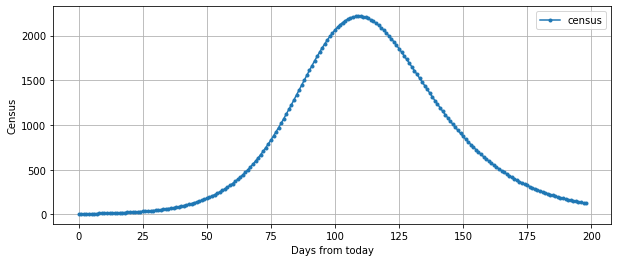

In [433]:
los_dict = {
    "cases": hosp_los#,
    #"icu": icu_los,
    #"vent": vent_los,
}

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

census_dict = {}
for k, los in los_dict.items():
    census = (
        projection_admits.cumsum().iloc[:-los, :]
        - projection_admits.cumsum().shift(los).fillna(0)
    ).apply(np.ceil)
    census_dict[k] = census[k]
    ax.plot(census.head(plot_projection_days)[k], ".-", label="census")
    ax.legend(loc=0)

ax.set_xlabel("Days from today")
ax.grid("on")
ax.set_ylabel("Census")

In [434]:
census_df = pd.DataFrame(census_dict)
census_df["day"] = census_df.index
census_df = census_df[["day", "cases"#, "icu", "vent"
                       ]]

census_table = census_df[np.mod(census_df.index, 7) == 0].copy()
census_table.index = range(census_table.shape[0])
census_table.loc[0, :] = 0
census_table = census_table.dropna().astype(int)
print(census_df)

     day  cases
0      0    6.0
1      1    7.0
2      2    7.0
3      3    8.0
4      4    8.0
5      5    9.0
6      6    9.0
7      7   10.0
8      8   11.0
9      9   12.0
10    10   12.0
11    11   13.0
12    12   14.0
13    13   15.0
14    14   16.0
15    15   17.0
16    16   18.0
17    17   20.0
18    18   21.0
19    19   22.0
20    20   24.0
21    21   26.0
22    22   28.0
23    23   29.0
24    24   32.0
25    25   34.0
26    26   36.0
27    27   39.0
28    28   41.0
29    29   44.0
..   ...    ...
170  170  400.0
171  171  384.0
172  172  368.0
173  173  353.0
174  174  339.0
175  175  325.0
176  176  312.0
177  177  299.0
178  178  287.0
179  179  275.0
180  180  264.0
181  181  253.0
182  182  243.0
183  183  233.0
184  184  223.0
185  185  214.0
186  186  205.0
187  187  196.0
188  188  188.0
189  189  180.0
190  190  173.0
191  191  166.0
192  192  159.0
193  193  152.0
194  194  146.0
195  195  139.0
196  196  134.0
197  197  128.0
198  198  123.0
199  199    NaN

[200 ro

In [435]:
#census_df4 = census_df
#census_df4[["day","Cases3"]] = census_df[["day","cases"]]
#census_df4["Cases3.5"] = census_df["cases"]
#census_df4["Cases4"] = census_df["cases"]
#census_df4["Cases4.5"] = census_df["cases"]
#census_df4["Cases5"] = census_df["cases"]
#census_df4["Cases6"] = census_df["cases"]
census_df4["Cases10"] = census_df["cases"]

#census_df4["Cases3"] = census_df["cases"]
print(census_df4)

#census_df.to_csv('NY.csv') 

     day   cases  Cases3  Cases3.5  Cases4  Cases4.5  Cases5  Cases6  Cases10
0      0     6.0     6.0       6.0     6.0       6.0     6.0     6.0      6.0
1      1     8.0     8.0       8.0     8.0       7.0     7.0     7.0      7.0
2      2    10.0    10.0       9.0     9.0       9.0     8.0     8.0      7.0
3      3    12.0    12.0      11.0    10.0      10.0     9.0     9.0      8.0
4      4    15.0    15.0      14.0    12.0      11.0    11.0    10.0      8.0
5      5    19.0    19.0      16.0    15.0      13.0    12.0    11.0      9.0
6      6    24.0    24.0      20.0    17.0      15.0    14.0    12.0      9.0
7      7    30.0    30.0      24.0    20.0      18.0    16.0    14.0     10.0
8      8    38.0    38.0      29.0    24.0      21.0    18.0    15.0     11.0
9      9    48.0    48.0      36.0    29.0      24.0    21.0    17.0     12.0
10    10    60.0    60.0      43.0    34.0      28.0    24.0    19.0     12.0
11    11    75.0    75.0      52.0    40.0      33.0    28.0    

In [439]:
multiple_agg_data = census_df4[census_df4['day'].isin([0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119,126])]
print(multiple_agg_data)

     day   cases  Cases3  Cases3.5  Cases4  Cases4.5  Cases5  Cases6  Cases10
0      0     6.0     6.0       6.0     6.0       6.0     6.0     6.0      6.0
7      7    30.0    30.0      24.0    20.0      18.0    16.0    14.0     10.0
14    14   149.0   149.0      94.0    67.0      51.0    41.0    30.0     16.0
21    21   709.0   709.0     365.0   220.0     148.0   108.0    67.0     26.0
28    28  2794.0  2794.0    1310.0   699.0     420.0   277.0   148.0     41.0
35    35  6119.0  6119.0    3625.0  1964.0    1118.0   688.0   321.0     66.0
42    42  6246.0  6246.0    5830.0  4102.0    2542.0  1565.0   678.0    107.0
49    49  4452.0  4452.0    5477.0  5394.0    4272.0  2968.0  1334.0    170.0
56    56  2864.0  2864.0    3971.0  4817.0    4917.0  4227.0  2314.0    268.0
63    63  1784.0  1784.0    2623.0  3538.0    4249.0  4445.0  3318.0    417.0
70    70  1097.0  1097.0    1671.0  2391.0    3152.0  3757.0  3805.0    632.0
77    77   671.0   671.0    1048.0  1558.0    2173.0  2810.0  35

Text(0.5, 1.0, 'PA Cases')

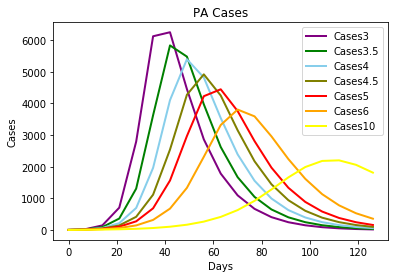

In [440]:
plt.plot( 'day', 'Cases3', data=multiple_agg_data, color='purple', linewidth=2)
plt.plot( 'day', 'Cases3.5', data=multiple_agg_data, color='green', linewidth=2)
plt.plot( 'day', 'Cases4', data=multiple_agg_data, color='skyblue', linewidth=2)
plt.plot( 'day', 'Cases4.5', data=multiple_agg_data, color='olive', linewidth=2)
plt.plot( 'day', 'Cases5', data=multiple_agg_data, color='red', linewidth=2)
plt.plot( 'day', 'Cases6', data=multiple_agg_data, color='orange', linewidth=2)
plt.plot( 'day', 'Cases10', data=multiple_agg_data, color='yellow', linewidth=2)

plt.legend()
plt.xlabel("Days")
plt.ylabel("Cases")
plt.title("PA Cases")

In [441]:
multiple_agg_data.to_csv('PA_Scenarios.csv') 